<a href="https://colab.research.google.com/github/SJP0308/MLTUTORIAL/blob/titanic/titanic3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **문제 정의**

**It is your job to predict if a passenger survived the sinking of the Titanic or not.**
For each in the test set, you must predict a 0 or 1 value for the variable.

# **평가 방식**

Your score is the percentage of passengers you correctly predict. This is known as **accuracy.**

# **Download**

In [1]:
# 데이터셋 다운로드
def download_dataset(datafile_name):
  from google.colab import drive
  drive.mount('/content/drive')
  path = f'/content/drive/My Drive/{datafile_name}'
  train_df = pd.read_csv(f'{path}/train.csv')
  test_df = pd.read_csv(f'{path}/test.csv')
  print('데이터 다운로드 완료!')
  return pd.concat([train_df, test_df], ignore_index=True)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# 경고 메시지를 무시하도록 설정
warnings.filterwarnings('ignore')

# 플롯을 인라인으로 표시하도록 설정
%matplotlib inline

df = download_dataset('titanic')

Mounted at /content/drive
데이터 다운로드 완료!


# **Features**

In [3]:
def fill_age_with_mean(age, title):
    if pd.isnull(age):
        mean_age = {'Master': 4, 'Miss': 21, 'Mr': 33, 'Mrs':35}
        return mean_age.get(title, age)
    return age

def extract_age_group(age):
    if pd.notnull(age):
        return int((age-0.01)//10)

def fill_fare_with_mean(Fare, Pclass):
    if pd.isnull(Fare):
        mean_fares = {1: 87.51, 2: 21.18, 3: 13.30}
        return mean_fares.get(Pclass, Fare)
    return round(Fare, 2)

In [4]:
title_mapping = {'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss', 'Dr': 'Mr', 'Major': 'Mr', 'Lady': 'Mrs',
    'Countess': 'Mrs', 'Jonkheer': 'Mr', 'Col': 'Mr', 'Rev': 'Mr', 'Capt': 'Mr', 'Sir': 'Mr',
    'Don': 'Mr', 'Dona': 'Mrs'}
df['Title'] = df['Name'].str.extract(' ([A-Z][a-z]+)\.')
df['Title'].replace(title_mapping, inplace=True)

df['Age'] = df.apply(lambda row: fill_age_with_mean(row['Age'], row['Title']), axis=1)
df['AgeGroup'] = df['Age'].apply(extract_age_group)

df['FamilySize'] = df['SibSp'] + df['Parch']
df['IsAlone'] = (df['FamilySize']==1).astype(int)

df['Fare'] = df.apply(lambda row: fill_fare_with_mean(row['Fare'], row['Pclass']), axis=1)

df['Embarked'] = df['Embarked'].fillna('S')

In [5]:
for col in ['Pclass', 'AgeGroup']:
  df[col] = df[col].apply(str)

df = df.drop(['PassengerId', 'Name', 'Age', 'SibSp',	'Parch', 'Ticket','Cabin'], axis=1)

# **Data processing**

In [6]:
# 스피어맨 인코딩
def Spearman_encode(df, feature):
    ordering = df.groupby(feature)['Survived'].mean().sort_values().reset_index()
    ordering['ordering'] = range(1, len(ordering)+1)
    df[feature] = df[feature].map(dict(zip(ordering[feature], ordering['ordering'])))
    return df

In [7]:
quantitative = df.select_dtypes(include='number').drop(columns=['Survived'])
qualitative = df.select_dtypes(include='object')

for col in qualitative:
  df = Spearman_encode(df, col)

In [8]:
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

quantitative = df.select_dtypes(include='number').columns[1:]
high_skew = quantitative[df[quantitative].apply(lambda x: skew(x)) > 0.5]
for col in high_skew.drop(labels=['Sex','IsAlone']):
    try:
        df[col] = boxcox1p(df[col], boxcox_normmax(df[col]+1))
    except Exception as e:
        print(f"Error processing column {col}: {e}")

In [9]:
df = pd.get_dummies(df)

# **model**

In [10]:
from sklearn.preprocessing import RobustScaler

rbst_scaler=RobustScaler()
X_train = rbst_scaler.fit_transform(df[df['Survived'].notnull()].drop('Survived', axis=1).values)
X_test = rbst_scaler.transform(df[df['Survived'].isnull()].drop('Survived', axis=1).values)
target_label = df[df['Survived'].notnull()]['Survived'].values

In [11]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
# KFold 설정
random_state = 42
kfold = KFold(n_splits=4, shuffle=True, random_state=random_state)

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True],  
    'criterion': ['gini']
}
gs_rf = GridSearchCV(rf, rf_param_grid, cv=kfold, scoring='accuracy')
gs_rf.fit(X_train, target_label)
rf_best = gs_rf.best_estimator_

gs_rf.best_score_

from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],  
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2],
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0],  
    'gamma': [0, 0.1, 0.2]
}
gs_xgb = GridSearchCV(xgb, xgb_param_grid, cv=kfold, scoring='accuracy')
gs_xgb.fit(X_train, target_label)
xgb_best = gs_xgb.best_estimator_

gs_xgb.best_score_

from lightgbm import LGBMClassifier

lgb = LGBMClassifier()
lgb_param_grid = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'max_depth': [-1, 3, 4, 5],  
    'num_leaves': [31, 63],  
    'min_data_in_leaf': [20, 30],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0]  
}
gs_lgb = GridSearchCV(lgb, lgb_param_grid, cv=kfold, scoring='accuracy')
gs_lgb.fit(X_train, target_label)
lgb_best = gs_lgb.best_estimator_

gs_lgb.best_score_

In [12]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

rf = RandomForestClassifier(n_estimators=200, max_depth=20,
                            min_samples_leaf=2).fit(X_train, target_label)
xgb = XGBClassifier(learning_rate=0.01,  n_estimators=200, max_depth=5, colsample_bytree=1.0,
                    subsample=0.8).fit(X_train, target_label)
lgb = LGBMClassifier(learning_rate=0.01, n_estimators=300, min_data_in_leaf=20,
                     subsample=0.8).fit(X_train, target_label)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

# **Ensemble**

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


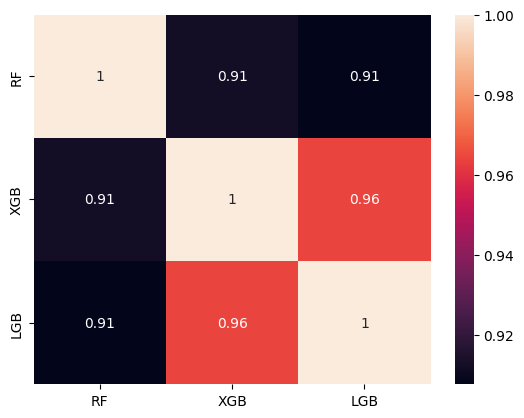

In [13]:
test_RF = pd.Series(rf.predict(X_test), name="RF")
test_XGB = pd.Series(xgb.predict(X_test), name="XGB")
test_LGB = pd.Series(lgb.predict(X_test), name="LGB")

ensemble_results = pd.concat([test_RF, test_XGB, test_LGB],axis=1)
g= sns.heatmap(ensemble_results.corr(),annot=True)

In [14]:
test_RF_prob = rf.predict_proba(X_test)[:,1]
test_XGB_prob = xgb.predict_proba(X_test)[:,1]
test_LGB_prob = lgb.predict_proba(X_test)[:,1]

ensemble_probs = (0.1*test_RF_prob + 0.8*test_XGB_prob + 0.1*test_LGB_prob)
pred = (ensemble_probs >= 0.5).astype(int)
submission = pd.read_csv('/content/drive/My Drive/titanic/gender_submission.csv')
submission['Survived'] = pred
submission.to_csv('./ensemble_answer.csv', index=False)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


In [15]:
from sklearn.ensemble import VotingClassifier

votingC = VotingClassifier(estimators=[('RF',rf), ('XGB', xgb), ('LGB', lgb)], n_jobs=-1)
votingC = votingC.fit(X_train, target_label)
vote = pd.Series(votingC.predict(X_test))
submission = pd.read_csv('/content/drive/My Drive/titanic/gender_submission.csv')
submission['Survived'] = vote.astype(int)
submission.to_csv('./vote_answer.csv', index=False)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


In [19]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

clf1 = rf
clf2 = xgb
clf3 = lgb

sc = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=LogisticRegression())
stacking = sc.fit(X_train, target_label)
stack = stacking.predict(X_test)

submission = pd.read_csv('/content/drive/My Drive/titanic/gender_submission.csv')
submission['Survived'] = stack.astype(int)
submission.to_csv('./stack_answer.csv', index=False)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from mlxtend.classifier import StackingCVClassifier

# KFold 정의
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# 개별 분류기 정의
ridge = make_pipeline(RobustScaler(), LogisticRegressionCV(cv=kfolds))
lasso = make_pipeline(RobustScaler(), LogisticRegressionCV(cv=kfolds))
enet = make_pipeline(RobustScaler(), LogisticRegressionCV(cv=kfolds))
svc = make_pipeline(RobustScaler(), SVC(C=20, gamma=0.0003, probability=True))

# 스태킹 모델 정의
stack_gen = StackingCVClassifier(classifiers=(ridge, lasso, enet, svc, rf, xgb, lgb),
                                  meta_classifier=LogisticRegressionCV(),
                                  use_features_in_secondary=True)

# 모델 학습
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(target_label))

# 각 모델 개별 학습
elastic_model = enet.fit(X_train, target_label)
lasso_model = lasso.fit(X_train, target_label)
ridge_model = ridge.fit(X_train, target_label)
svc_model = svc.fit(X_train, target_label)
rf_model = rf.fit(X_train, target_label)
xgb_model = xgb.fit(X_train, target_label)
lgb_model = lgb.fit(X_train, target_label)

# 예측 함수 정의
def blend_models_predict(X):
    elastic_prob = elastic_model.predict_proba(X)[:, 1]
    lasso_prob = lasso_model.predict_proba(X)[:, 1]
    ridge_prob = ridge_model.predict_proba(X)[:, 1]
    svc_prob = svc_model.predict_proba(X)[:, 1]
    rf_prob = rf_model.predict_proba(X)[:, 1]
    xgb_prob = xgb_model.predict_proba(X)[:, 1]
    lgb_prob = lgb_model.predict_proba(X)[:, 1]
    stack_prob = stack_gen_model.predict_proba(X)[:, 1]

    blended_prob = (0.1 * elastic_prob +
                    0.1 * lasso_prob +
                    0.1 * ridge_prob +
                    0.1 * svc_prob +
                    0.1 * rf_prob +
                    0.15 * xgb_prob +
                    0.1 * lgb_prob +
                    0.25 * stack_prob)

    return (blended_prob >= 0.5).astype(int)

# 데이터 로드 및 예측
blend = blend_models_predict(X_test)
submission = pd.read_csv('/content/drive/My Drive/titanic/gender_submission.csv')
submission['Survived'] = blend.astype(int)
submission.to_csv('./blend_answer.csv', index=False)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 171, number of negative: 274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 445, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384270 -> initscore=-0.471465
[LightGBM] [Info] Start training from score -0.471465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai